# Análisis de Palmer Penguins con Trees
Dataset de pingüinos para clasificación con Random Forest y XGBoost


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb


## 1. Gradient Descent 3D (función simple)


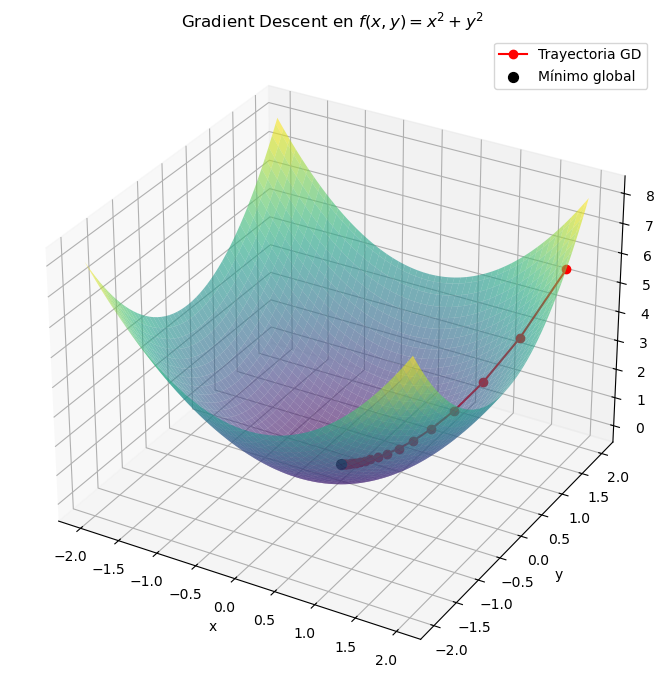

In [2]:
from mpl_toolkits.mplot3d import Axes3D

# Función y gradiente
def f(x, y):
    return x**2 + y**2

def grad_f(x, y):
    return np.array([2*x, 2*y])

# Inicialización
x_vals = [2.0]
y_vals = [1.5]
eta = 0.1
n_iter = 20

x, y = x_vals[0], y_vals[0]
for _ in range(n_iter):
    grad = grad_f(x, y)
    x -= eta * grad[0]
    y -= eta * grad[1]
    x_vals.append(x)
    y_vals.append(y)

z_vals = [f(x, y) for x, y in zip(x_vals, y_vals)]

# Crear malla 3D
X = np.linspace(-2, 2, 100)
Y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(X, Y)
Z = f(X, Y)

# Gráfica 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Superficie
ax.plot_surface(X, Y, Z, alpha=0.6, cmap='viridis', edgecolor='none')

# Ruta de descenso
ax.plot(x_vals, y_vals, z_vals, color='red', marker='o', label='Trayectoria GD')
ax.scatter(0, 0, 0, color='black', s=50, label='Mínimo global')

# Etiquetas
ax.set_title("Gradient Descent en $f(x,y) = x^2 + y^2$")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x,y)")
ax.legend()
plt.tight_layout()
plt.show()


In [3]:
# Cargar dataset de penguins
penguins = sns.load_dataset('penguins')
print("Dataset original:")
print(penguins.head())
print(f"\nShape: {penguins.shape}")
print(f"\nValores nulos:\n{penguins.isnull().sum()}")


Dataset original:
  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
3          NaN     NaN  
4       3450.0  Female  

Shape: (344, 7)

Valores nulos:
species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64


In [4]:
# Preprocesamiento: eliminar nulos y seleccionar variables numéricas
penguins_clean = penguins.dropna()

# Variables numéricas como features
X = penguins_clean[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
y = penguins_clean['species']

print(f"Datos limpios: {X.shape}")
print(f"Clases: {y.unique()}")


Datos limpios: (333, 4)
Clases: ['Adelie' 'Chinstrap' 'Gentoo']


In [5]:
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluar
y_pred = rf.predict(X_test)
print("Accuracy en test:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Accuracy en test: 0.99

Reporte de clasificación:
              precision    recall  f1-score   support

      Adelie       0.98      1.00      0.99        48
   Chinstrap       1.00      0.94      0.97        18
      Gentoo       1.00      1.00      1.00        34

    accuracy                           0.99       100
   macro avg       0.99      0.98      0.99       100
weighted avg       0.99      0.99      0.99       100



Importancias MDI de las variables:
bill_length_mm       0.370147
bill_depth_mm        0.316284
flipper_length_mm    0.237150
body_mass_g          0.076420
dtype: float64


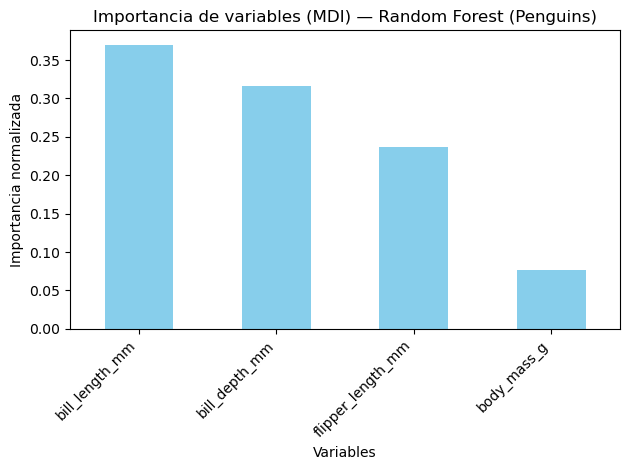

In [6]:
# Obtener importancias MDI (feature_importances_)
importances = rf.feature_importances_

# Emparejar con nombres de características
feat_imp = pd.Series(importances, index=X.columns)

# Ordenar de mayor a menor
feat_imp_sorted = feat_imp.sort_values(ascending=False)
print("Importancias MDI de las variables:")
print(feat_imp_sorted)

# Visualizar
feat_imp_sorted.plot(kind='bar', color='skyblue')
plt.title("Importancia de variables (MDI) — Random Forest (Penguins)")
plt.ylabel("Importancia normalizada")
plt.xlabel("Variables")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 3. XGBoost con Palmer Penguins


In [7]:
# XGBoost requiere etiquetas numéricas para clasificación
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Mapeo de clases:")
for i, clase in enumerate(le.classes_):
    print(f"{i}: {clase}")


Mapeo de clases:
0: Adelie
1: Chinstrap
2: Gentoo


In [8]:
# Separar en train/test con etiquetas codificadas
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Crear y entrenar modelo XGBoost Classifier
model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# Evaluar desempeño
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.99

Reporte de clasificación:
              precision    recall  f1-score   support

      Adelie       0.98      1.00      0.99        48
   Chinstrap       1.00      0.94      0.97        18
      Gentoo       1.00      1.00      1.00        34

    accuracy                           0.99       100
   macro avg       0.99      0.98      0.99       100
weighted avg       0.99      0.99      0.99       100




Importancia de variables (Gain):
             Feature  Importance (Gain)
2  flipper_length_mm           2.116188
0     bill_length_mm           2.054033
1      bill_depth_mm           1.979299
3        body_mass_g           0.839174


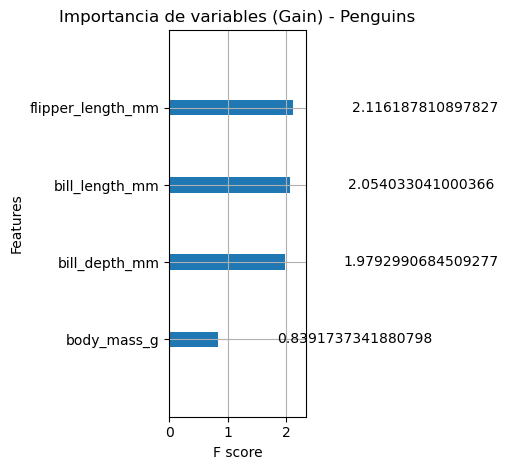

In [9]:
# Importancia de variables (tipo 'gain')
importance = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance (Gain)': list(importance.values())
}).sort_values(by='Importance (Gain)', ascending=False)

print("\nImportancia de variables (Gain):")
print(importance_df)

# Visualizar importancias
xgb.plot_importance(model, importance_type='gain', title="Importancia de variables (Gain) - Penguins", show_values=True)
plt.tight_layout()
plt.show()


## 4. Comparación de importancias



Comparación normalizada de importancias:
                   Random Forest (MDI)  XGBoost (Gain)
bill_length_mm                1.000000        0.970629
bill_depth_mm                 0.854482        0.935314
flipper_length_mm             0.640691        1.000000
body_mass_g                   0.206458        0.396550


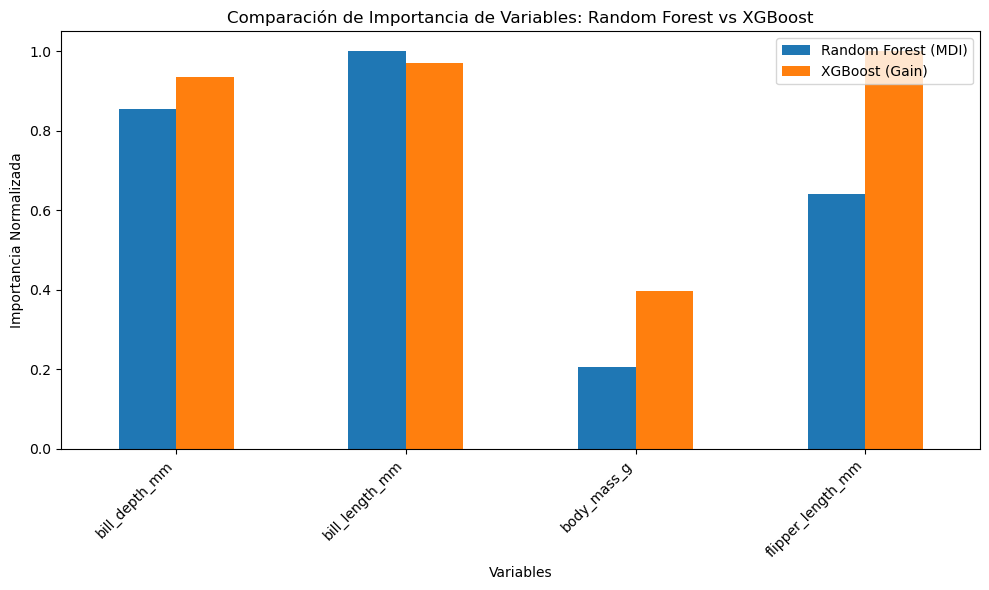

In [10]:
# Crear DataFrame comparativo
comparison = pd.DataFrame({
    'Random Forest (MDI)': feat_imp_sorted,
    'XGBoost (Gain)': importance_df.set_index('Feature')['Importance (Gain)'].sort_index()
})

# Normalizar para comparar en la misma escala
comparison_norm = comparison / comparison.max()

print("\nComparación normalizada de importancias:")
print(comparison_norm.sort_values(by='Random Forest (MDI)', ascending=False))

# Visualizar comparación
comparison_norm.plot(kind='bar', figsize=(10, 6))
plt.title("Comparación de Importancia de Variables: Random Forest vs XGBoost")
plt.ylabel("Importancia Normalizada")
plt.xlabel("Variables")
plt.xticks(rotation=45, ha='right')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
